# Geting text in the wild in natural images

In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import coco_text
from PIL import Image

We are using the coco text annotations for the coco dataset.

In [2]:
ct = coco_text.COCO_Text('cocotext.v2.json')

loading annotations into memory...
0:00:01.670679
creating index...
index created!


## Preparing the dataset along with the respective image annotations of text

In [3]:
from detectron2.structures import BoxMode

def get_coco_dict(img_dir,d):
    dataset_dicts = []
    if d.find('train') !=-1:
        imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility','legible')])
    elif d.find('val') != -1:
        imgIds = ct.getImgIds(imgIds=ct.val, catIds=[('legibility','legible')])
    for ids in imgIds:
        record = {}
        img = ct.loadImgs(ids)[0]
        filename = os.path.join(img_dir, img["file_name"])        
        record["file_name"] = filename
        record["image_id"] = ids
        record["height"] = img['height']
        record["width"] = img['width']
      
        annoIds = ct.getAnnIds(imgIds = ids)
        annos = ct.loadAnns(annoIds)
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": 0 if anno['language']=='english' else 1,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train2014", "val2014"]:
    DatasetCatalog.register("coco_text_" + d, lambda d=d: get_coco_dict("/coco/train2014/",d))
    MetadataCatalog.get("coco_text_" + d).set(thing_classes=["english","others",])
coco_text_metadata = MetadataCatalog.get("coco_text_train2014")

Using the Facebook detectron2 COCO Object detection model from the model zoo to retrain on text annotations

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_text_train2014",)
cfg.DATASETS.TEST = ("coco_text_val2014",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 30000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[12/21 08:02:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/ext3/miniconda3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/ext3/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/21 08:02:28 d2.utils.events]:  eta: 1:11:53  iter: 25019  total_loss: 0.6202  loss_cls: 0.1745  loss_box_reg: 0.2345  loss_rpn_cls: 0.04721  loss_rpn_loc: 0.1216  time: 0.8689  data_time: 0.0903  lr: 0.00025  max_mem: 9433M
[12/21 08:02:46 d2.utils.events]:  eta: 1:12:39  iter: 25039  total_loss: 0.5987  loss_cls: 0.1806  loss_box_reg: 0.2185  loss_rpn_cls: 0.05219  loss_rpn_loc: 0.1411  time: 0.8749  data_time: 0.0086  lr: 0.00025  max_mem: 9434M
[12/21 08:03:03 d2.utils.events]:  eta: 1:12:35  iter: 25059  total_loss: 0.6128  loss_cls: 0.1756  loss_box_reg: 0.2318  loss_rpn_cls: 0.05419  loss_rpn_loc: 0.1415  time: 0.8758  data_time: 0.0087  lr: 0.00025  max_mem: 9434M
[12/21 08:03:21 d2.utils.events]:  eta: 1:12:17  iter: 25079  total_loss: 0.6117  loss_cls: 0.1819  loss_box_reg: 0.2401  loss_rpn_cls: 0.05304  loss_rpn_loc: 0.1378  time: 0.8746  data_time: 0.0088  lr: 0.00025  max_mem: 9434M
[12/21 08:03:38 d2.utils.events]:  eta: 1:11:59  iter: 25099  total_loss: 0.5807  loss_c

In [49]:
!conda clean -a -y

Cache location: 
There are no tarballs to remove
Cache location: /ext3/miniconda3/pkgs
Will remove the following packages:
/ext3/miniconda3/pkgs
---------------------

blas-1.0-mkl                                  15 KB
libwebp-base-1.2.0-h27cfd23_0                2.8 MB
pytorch-mutex-1.0-cuda                         7 KB
numpy-1.21.2-py39h20f2e39_0                   72 KB

---------------------------------------------------
Total:                                       2.9 MB

removing blas-1.0-mkl
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(143): Could not remove or rename /ext3/miniconda3/pkgs/blas-1.0-mkl/info/recipe/parent/deuniversalize.py.  Please remove this file manually (you may need to reboot to free file handles)
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(143): Could not remove or rename /ext3/miniconda3/pkgs/blas-1.0-mkl/info/recipe/parent/install-devel.sh.  Please remove this file manually (you may need to reboot to free file handles)
WAR

In [47]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |███████████████████▍            | 296.6 MB 117.3 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 489.7 MB 28 kB/s /s eta 0:00:01
     |████████████████████████████████| 2.1 MB 149.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 155.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 140.3 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 146.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 2.1 MB/s s eta 0:00:01
     |████████████████████████████████| 13.4 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 11.5 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 658 kB/s s eta 0:00:01
     |████████████████████████████████| 81 kB 29.4 MB/s  eta 0:00:01
ERROR: Could not install packages due to an OSError: [Errno 122] Disk quota exceeded



In [46]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2486075), started 2:04:52 ago. (Use '!kill 2486075' to kill it.)

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/ext3/miniconda3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


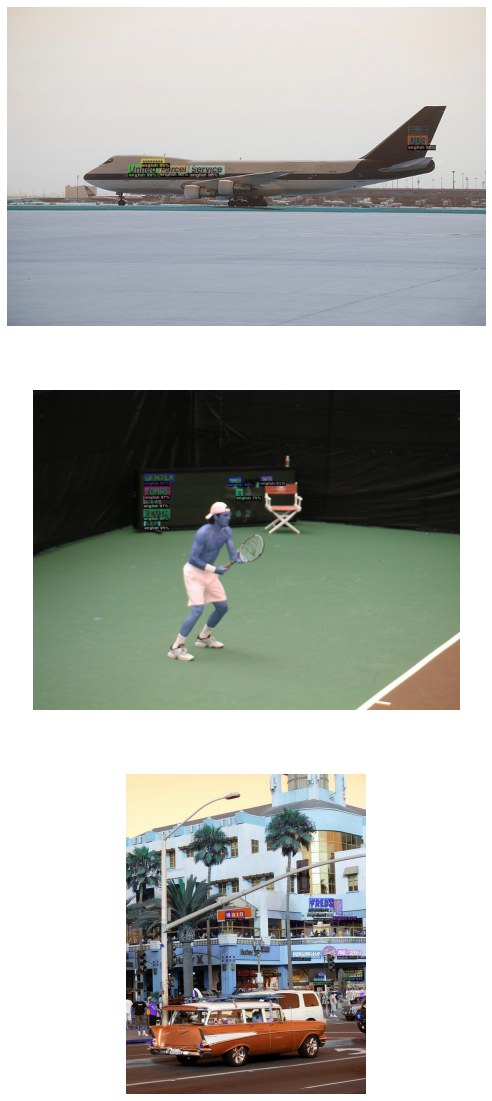

In [9]:
from detectron2.utils.visualizer import ColorMode
import skimage.io as io
imgIds = ct.getImgIds(imgIds=ct.val, catIds=[('legibility','legible')])
plt.figure(figsize=(20,20))
for d in range(3):    
    img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    im = cv2.imread('/coco/train2014/'+img['file_name'])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=coco_text_metadata, 
                   scale=1,
                   instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.subplot(3,1,d+1)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
plt.show()

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("coco_text_val2014", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "coco_text_val2014")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/21 09:27:57 d2.evaluation.coco_evaluation]: Trying to convert 'coco_text_val2014' to COCO format ...
WARNING [12/21 09:27:57 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/coco_text_val2014_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[12/21 09:27:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/21 09:27:57 d2.data.common]: Serializing 3261 elements to byte tensors and concatenating them all ...
[12/21 09:27:57 d2.data.common]: Serialized dataset takes 2.29 MiB
[12/21 09:27:57 d2.evaluation.evaluator]: Start inference on 3261 batches
[12/21 09:27:59 d2.evaluation.evaluator]: Inference done 11/3261. Dataloading: 0.0007 s/iter. Inference: 0.0444 s/iter. Eval: 0.0001 s/iter. Total: 0.0452 s/iter. ETA=0:02:27
[12/21 09:28:04 d2.evaluation.evaluator]: Inference done 105/3261. Dataloading: 

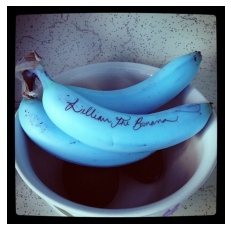

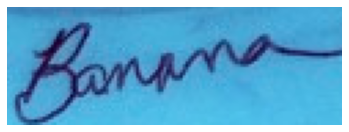

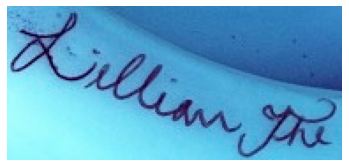

In [36]:
def crop_object(image, box):
    x_top_left = int(box[0])
    y_top_left = int(box[1])
    x_bottom_right = int(box[2])
    y_bottom_right = int(box[3])
    x_center = (x_top_left + x_bottom_right) / 2
    y_center = (y_top_left + y_bottom_right) / 2
    
    crop_img = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
    return crop_img

imgIds = ct.getImgIds(imgIds=ct.val, catIds=[('legibility','legible')])
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image = cv2.imread('/coco/train2014/'+img['file_name'])
outputs = predictor(image)
boxes = outputs["instances"].to('cpu').pred_boxes
#box = list(boxes)[0].detach().cpu().numpy()
plt.imshow(image)
plt.axis("off")
plt.show()
for i,box in enumerate(boxes):
    crop_img = crop_object(image,box)
    plt.imshow(crop_img)
    plt.axis("off")
    plt.show()
    cv2.imwrite("/scratch/ac9025/test_images/"+img['file_name']+"_cropped_"+str(i)+".png", crop_img)